In [60]:
% matplotlib inline
import os
import sys
import importlib
import pickle
import pprint

import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import scipy.stats as stats

import redfin
import homepricemodels

importlib.reload(redfin)
importlib.reload(homepricemodels)


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error, r2_score


seaborn.set_context(context='talk')

pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', lambda x: '%.4f' % x)




## Scraping using the `redfin.py` module:

All scraping is done using the `redfin` module. To scrape the website Redfin.com, `redfin` first collects all the relative URLs from the landing page using `redfin.save_links_for_every_zipcode(zipcode_dict, page_range=18)` which packages the URLs into one Pickle file for every zip code. 

`combine_zipcode_listings_pickles_into_one(pickle_directory='pickles/')` combines the various zip code .pkl files into one combined .pkl file.

## Data Analysis using the `homepricemodels.py` module:



### Loading and splitting data:

In [55]:
combined_home_stats = homepricemodels.load_all_home_stats(pickle_file='pickles/combined_home_stats.pkl')
df = homepricemodels.clean_home_stats_df(combined_home_stats)

X_all, y_all = homepricemodels.get_engineered_features(df, cross_terms=True)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=0)

/Users/timcodes/ds/metis/metisgh/02_Luther/Luther/homepricemodels.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[cross_term] = X[popped] * X[col]


### Exploratory Data Analysis:


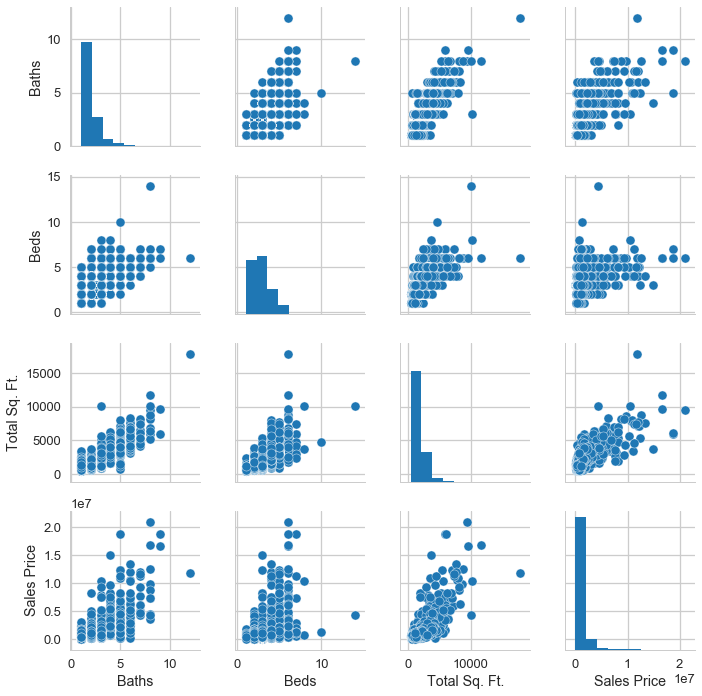

In [56]:
seaborn.pairplot(df.loc[:,['Baths','Beds','Total Sq. Ft.','Sales Price']]);

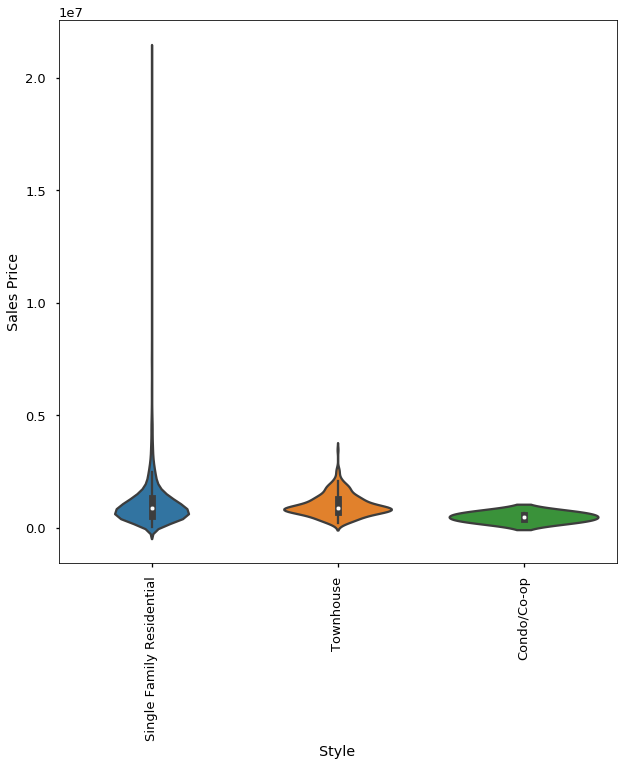

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
seaborn.violinplot(x="Style", y="Sales Price", data=df, jitter=False)
plt.xticks(rotation='vertical');

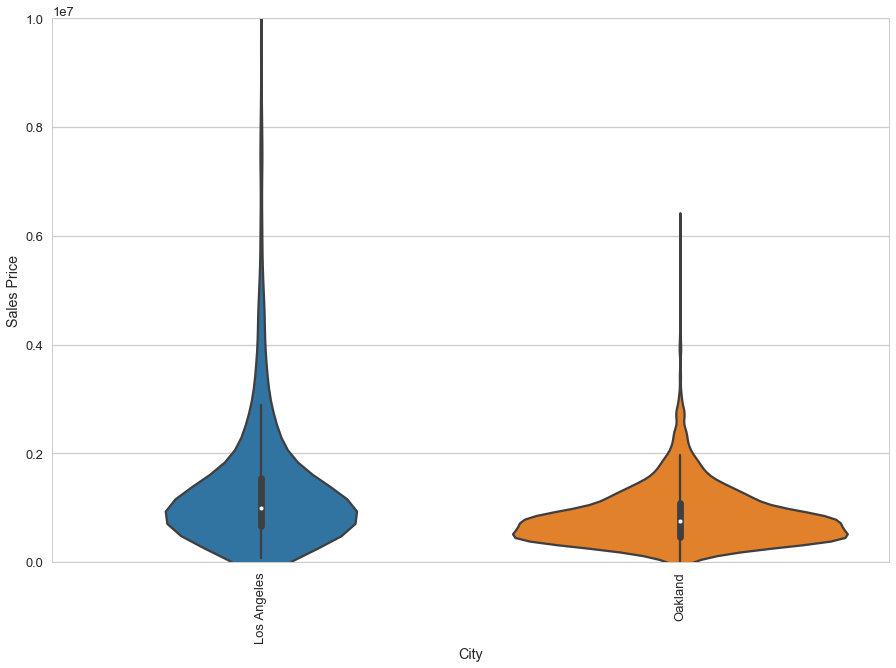

In [16]:
seaborn.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,10))
seaborn.violinplot(x="City", y="Sales Price", data=df)
plt.xticks(rotation='vertical')
plt.ylim([0,10000000]);

### Analysis and manual model selection using Statsmodels and linear features

For a first model, I've iteratively selected features based on two criteria:
- The **p-value** must be low (typically less than 0.05) to ensure statistical significance of the coefficients
- The **VIF** (Variance Inflation Factor) must be low (typically less than 5) to minimize multicollinearity.

The following list is the result of downselecting features based on the above criteria:

In [23]:
regressables = ['Total Sq. Ft.',  
                'Lot Size Sq. Ft.', 
                'Townhouse', 
                '90024', '90026', 
                '90041', '90049', '90056', 
                '90221', 
                '90301', '90403', '94601', '94602', 
                '94605', '94606', '94607', '94609', '94610', '94611', '94618', '94619',
               ]

The list `regressables` is at least as interesting for what it doesn't contain that for what is does. Absent from the list are a large number of columns, including `Beds` and `Baths`. This is because those kinds of features are highly collinear with another feature, `Total Sq. Ft.`, which won out as the most significant of the size-dependent multicollinear features. 

Let's look at the VIF (Variance Inflation Factor), a key consideration in the model selection. The VIF helps pinpoint regressors that are highly collinear with each other. To compute it (one VIF score for each feature), I wrote the wrapper `get_vif`. Notice that the VIF analysis doesn't require any information about the target variable. Instead, `get_vif` only needs the design matrix `X_train` to perform a set of auxiliary regressions, which reveal those features that are effectively linear combinations of the other features. I removed those features where the VIF was above 5, leaving the following features in place:

In [50]:
homepricemodels.get_vif(X_train[regressables])

,VIF,Features
0,3.0534,Total Sq. Ft.
1,1.3051,Lot Size Sq. Ft.
2,1.5105,Townhouse
3,1.0716,90024
4,1.0637,90026
5,1.0982,90041
6,1.3714,90049
7,1.1839,90056
8,1.0664,90221
9,1.0575,90301


#### p-values:

Next, you'll see the statsmodels summary for the Linear fit using the features in `regressables`. Note, in particular, the column `P>|t|`, with **p-values** < 0.05 for the most part.

                            OLS Regression Results                            
Dep. Variable:            Sales Price   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     296.3
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        15:55:33   Log-Likelihood:                -45643.
No. Observations:                3073   AIC:                         9.133e+04
Df Residuals:                    3051   BIC:                         9.146e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.978e+04   3.63e+04  

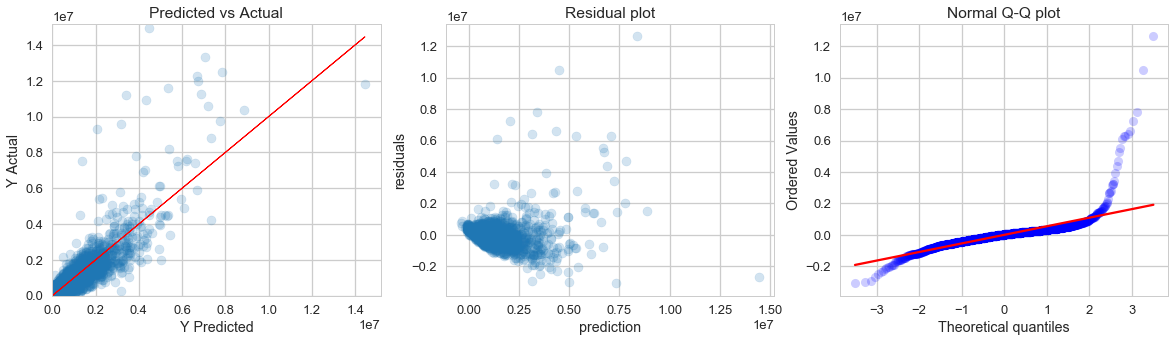

In [45]:
ols = homepricemodels.sm_ols_wrapper(y_train['Sales Price'],X_train[regressables])

As can be seen from the _Diagnostic Plots_ above, the ordinary least squares with linear terms captures a good chunk of the data fairly well, but breaks down for the outliers, particularly those at the high end of the `Sales Price` spectrum. 

#### $R^2$:
The $R^2$ and $R_{adj}^2$ for this model is about 0.67 as evaluated on the **Training Set**.

Let's evaluate the quality of this model on the **Test Set**:

In [49]:
print('OLS R^2 for the test set = {0:.2f} '.format((
       r2_score(y_test['Sales Price'],ols.predict( sm.add_constant(X_test[regressables])))))
     )
     

OLS R^2 for the test set = 0.66 


### A second model: adding in target scaling, more features, model selection, and regularization

Overall, the power of prediction is low using a simple linear model, so next we'll try to do better by adding a number of tools to the mix:
- Take the square root of the target to address the highly non-linear trends in home prices.
- Add cross terms to the list of features
- Since the addition of cross-terms drastically increases the number of features to select from, we'll also want to add a **Model Selection** algorithm to help with the complexity involved.
- Use regularization, specifically `Lasso` regularization

The above features are implemented in a series of functions that are called by the wrapper `homepricemodels.lasso_loop`:

In [62]:
reg, not_null_list, features = homepricemodels.lasso_loop(X_train.select_dtypes(include=['float64','uint8']), y_train['Sqrt Sales Price'])

The design matrix has 630 features.
# Tuning hyper-parameters for r2



/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

Best parameters set found on development set:

{'alpha': 0.01, 'normalize': True}

Grid scores on development set:

0.8049 (+/-0.0946) for {'alpha': 0.0001, 'normalize': True}
0.8048 (+/-0.0944) for {'alpha': 0.0001, 'normalize': False}
0.8067 (+/-0.0916) for {'alpha': 0.001, 'normalize': True}
0.8050 (+/-0.0944) for {'alpha': 0.001, 'normalize': False}
0.8161 (+/-0.0820) for {'alpha': 0.01, 'normalize': True}
0.8056 (+/-0.0939) for {'alpha': 0.01, 'normalize': False}
0.8157 (+/-0.0769) for {'alpha': 0.1, 'normalize': True}
0.8075 (+/-0.0934) for {'alpha': 0.1, 'normalize': False}
0.6465 (+/-0.1247) for {'alpha': 1, 'normalize': True}
0.8130 (+/-0.0830) for {'alpha': 1, 'normalize': False}
-0.0008 (+/-0.0007) for {'alpha': 10, 'normalize': True}
0.8112 (+/-0.0836) for {'alpha': 10, 'normalize': False}
-0.0008 (+/-0.0007) for {'alpha': 100, 'normalize': True}
0.8112 (+/-0.0825) for {'alpha': 100, 'normalize': False}

{'alpha': 0.01, 'normalize': True}
('Baths', 0.0)
('Beds', -0.0)
('Tot

/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

Best parameters set found on development set:

{'alpha': 1, 'normalize': False}

Grid scores on development set:

0.8190 (+/-0.0828) for {'alpha': 0.0001, 'normalize': True}
0.8188 (+/-0.0829) for {'alpha': 0.0001, 'normalize': False}
0.8200 (+/-0.0810) for {'alpha': 0.001, 'normalize': True}
0.8189 (+/-0.0829) for {'alpha': 0.001, 'normalize': False}
0.8237 (+/-0.0727) for {'alpha': 0.01, 'normalize': True}
0.8197 (+/-0.0823) for {'alpha': 0.01, 'normalize': False}
0.8175 (+/-0.0732) for {'alpha': 0.1, 'normalize': True}
0.8224 (+/-0.0822) for {'alpha': 0.1, 'normalize': False}
0.6338 (+/-0.1214) for {'alpha': 1, 'normalize': True}
0.8251 (+/-0.0883) for {'alpha': 1, 'normalize': False}
-0.0008 (+/-0.0007) for {'alpha': 10, 'normalize': True}
0.8155 (+/-0.0891) for {'alpha': 10, 'normalize': False}
-0.0008 (+/-0.0007) for {'alpha': 100, 'normalize': True}
0.8151 (+/-0.0875) for {'alpha': 100, 'normalize': False}

{'alpha': 1, 'normalize': False}
('Total Sq. Ft.', 0.12827483966702644)


/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

Best parameters set found on development set:

{'alpha': 1, 'normalize': False}

Grid scores on development set:

0.8237 (+/-0.0878) for {'alpha': 0.0001, 'normalize': True}
0.8238 (+/-0.0880) for {'alpha': 0.0001, 'normalize': False}
0.8235 (+/-0.0866) for {'alpha': 0.001, 'normalize': True}
0.8238 (+/-0.0879) for {'alpha': 0.001, 'normalize': False}
0.8231 (+/-0.0794) for {'alpha': 0.01, 'normalize': True}
0.8238 (+/-0.0879) for {'alpha': 0.01, 'normalize': False}
0.8155 (+/-0.0761) for {'alpha': 0.1, 'normalize': True}
0.8243 (+/-0.0871) for {'alpha': 0.1, 'normalize': False}
0.6336 (+/-0.1220) for {'alpha': 1, 'normalize': True}
0.8255 (+/-0.0884) for {'alpha': 1, 'normalize': False}
-0.0008 (+/-0.0007) for {'alpha': 10, 'normalize': True}
0.8156 (+/-0.0899) for {'alpha': 10, 'normalize': False}
-0.0008 (+/-0.0007) for {'alpha': 100, 'normalize': True}
0.8152 (+/-0.0882) for {'alpha': 100, 'normalize': False}

{'alpha': 1, 'normalize': False}
('Total Sq. Ft.', 0.12846481749119804)


`lasso_loop` begins with 

In [69]:
print('{} features'.format(len(X_train.select_dtypes(include=['float64','uint8']).columns)))

630 features


and downselects to 

In [70]:
print('{} features'.format(len(features)))

57 features


by iteratively dropping features with `coeff_ = 0`.

We can inspect the VIF of the resulting design matrix:

In [72]:
homepricemodels.get_vif(X_train[features])

,VIF,Features
0,175.7396,Total Sq. Ft.
1,20750.3068,Year Built
2,20967.9666,Year Renovated
3,3.3283,94619*Lot Size Sq. Ft.
4,16.2882,94618*Beds
5,14.9363,94618*Year Renovated
6,4.2293,94618*Lot Size Sq. Ft.
7,6.5682,94611*Total Sq. Ft.
8,5.8848,94611*Lot Size Sq. Ft.
9,1.9160,94610*Lot Size Sq. Ft.


There are many features that seem to be highly collinear. However, the predictive performance of this model is significantly better than the OLS model's:

In [76]:
y_pred=(reg.predict(X_test[features]))**2
y_true = y_test['Sales Price']

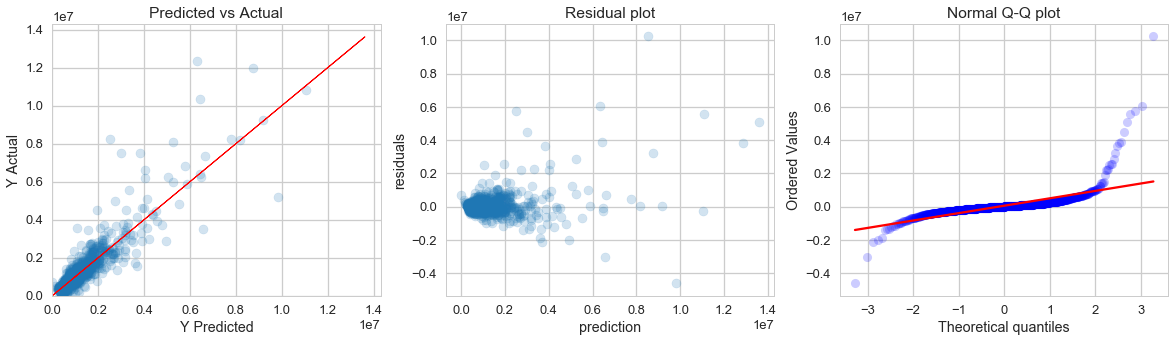

In [77]:
homepricemodels.diagnostic_plot(y_pred, y_true)

In [79]:
print('R^2 of the optimized Lasso model on the Test Set = {0:.2f}'.format(r2_score(y_true, y_pred)))

R^2 of the optimized Lasso model on the Test Set = 0.82


### Use the Linear Regression model as budgeting tool for a home remodel 

Finally, I'm creating idalized model inputs to help answer the question addressed in the Presentation "Is Adding That Bedroom Worth It?" The goal of this analysis is to use a regression model to find out how changes in home features, all else being equal, affect the value of the home. 

Effectively, this use of regression would work as a budgeting tool. If the model suggests that adding a bedroom and a bathroom (and 400 Sq. Ft.) to a home's living area would increase the home value by $100,000, then any remodel design budget below that threshold would have a reasonable chance of being recouped once the home is sold. 

The results of this analysis are:

#### Bath and Bedroom addition in zip code 94605 (Eastmont Hills, Oakland):


| Baths        | Beds          | Tot. Sq. Ft.  | Predicted Price | Dif Predicted Price |
| ------------ |:-------------:| -------------:| --------------: | ----------------:   |
| 1            | 2             | 1,700         | \$793,459       |                \$0  |
| 1            | 3             |   1,900       | \$837,277       | \$43,818            |
| 2            | 3             |    2,100      | \$882,274       | \$88,815            |


#### Bath and Bedroom addition in zip code 90056 (Ladeira Hts, Los Angeles):


| Baths        | Beds          | Tot. Sq. Ft.  | Predicted Price | Dif Predicted Price |
| ------------ |:-------------:| -------------:| --------------: | ----------------:   |
| 1            | 2             | 1,700         | \$1,215,749     |                \$0  |
| 1            | 3             |   1,900       | \$1,269,849     | \$54,100            |
| 2            | 3             |    2,100      | \$1,325,126     | \$109,377           |


These results are pretty interesting. First of all, note that for the same set of features (Bedrooms, Bathrooms, Square Footage, Lot Size, etc), an equivalent home in Ladeira Heights is 53% more expensive than in Eastmont Hills. Yet the difference in value due to feature addition varies by only about 24%. This suggests that adding to your home in a low priced neighborhood can be a decent investment.

Finally, let's do a reality check by finding the median values of the same 6 types of homes featured above. Here, we're getting a very different angle on the question.

In [111]:
print('2 Beds, 1 Bath in 94605: ${0:.0f}'.format(df.loc[(df['Zip Code']=='94605')&
          (df['Beds']==2.0)&
          (df['Baths']==1.0),
              'Sales Price'
         ].median()))

print('3 Beds, 1 Baths in 94605: ${0:.0f}'.format(df.loc[(df['Zip Code']=='94605')&
          (df['Beds']==3.0)&
          (df['Baths']==1.0),
              'Sales Price'
         ].median()))

print('3 Beds, 2 Baths in 94605: ${0:.0f}'.format(df.loc[(df['Zip Code']=='94605')&
          (df['Beds']==3.0)&
          (df['Baths']==2.0),
              'Sales Price'
         ].median()))

print('2 Beds, 1 Bath in 90056: ${0:.0f}'.format(df.loc[(df['Zip Code']=='90056')&
          (df['Beds']==2.0)&
          (df['Baths']==1.0),
              'Sales Price'
         ].median()))

print('3 Beds, 1 Baths in 90056: ${0:.0f}'.format(df.loc[(df['Zip Code']=='90056')&
          (df['Beds']==3.0)&
          (df['Baths']==1.0),
              'Sales Price'
         ].median()))

print('3 Beds, 2 Baths in 90056: ${0:.0f}'.format(df.loc[(df['Zip Code']=='90056')&
          (df['Beds']==3.0)&
          (df['Baths']==2.0),
              'Sales Price'
         ].median()))

2 Beds, 1 Bath in 94605: $420000
3 Beds, 1 Baths in 94605: $505000
3 Beds, 2 Baths in 94605: $715000
2 Beds, 1 Bath in 90056: $557000
3 Beds, 1 Baths in 90056: $638900
3 Beds, 2 Baths in 90056: $890000


The valuation difference for the median homes is far greater when computed this way. The difference between a 2Bed+1Bath and a 3 Bed + 2 Bath home in 94605 is almost \$300,000 and over \$330,000 in Ladeira Hts. 

So which model is to be believed, the regression model or the "filtered median" model that I just whipped up? It's hard to say because they can't be easily compared. For one, the regression model doesn't compute the median and its math achieves something closer to the mean:

In [112]:
print('2 Beds, 1 Bath in 94605: ${0:.0f}'.format(df.loc[(df['Zip Code']=='94605')&
          (df['Beds']==2.0)&
          (df['Baths']==1.0),
              'Sales Price'
         ].mean()))

print('3 Beds, 1 Baths in 94605: ${0:.0f}'.format(df.loc[(df['Zip Code']=='94605')&
          (df['Beds']==3.0)&
          (df['Baths']==1.0),
              'Sales Price'
         ].mean()))

print('3 Beds, 2 Baths in 94605: ${0:.0f}'.format(df.loc[(df['Zip Code']=='94605')&
          (df['Beds']==3.0)&
          (df['Baths']==2.0),
              'Sales Price'
         ].mean()))

print('2 Beds, 1 Bath in 90056: ${0:.0f}'.format(df.loc[(df['Zip Code']=='90056')&
          (df['Beds']==2.0)&
          (df['Baths']==1.0),
              'Sales Price'
         ].mean()))

print('3 Beds, 1 Baths in 90056: ${0:.0f}'.format(df.loc[(df['Zip Code']=='90056')&
          (df['Beds']==3.0)&
          (df['Baths']==1.0),
              'Sales Price'
         ].mean()))

print('3 Beds, 2 Baths in 90056: ${0:.0f}'.format(df.loc[(df['Zip Code']=='90056')&
          (df['Beds']==3.0)&
          (df['Baths']==2.0),
              'Sales Price'
         ].mean()))

2 Beds, 1 Bath in 94605: $408778
3 Beds, 1 Baths in 94605: $472593
3 Beds, 2 Baths in 94605: $691665
2 Beds, 1 Bath in 90056: $557000
3 Beds, 1 Baths in 90056: $638900
3 Beds, 2 Baths in 90056: $883848


But even here the differences are just as glaring. For the next caveat, however, there's no easy fix: the simple mean and median calculations cannot adjust for the differences in other factors, such as lot size, or a tight control over how much square footage is added with the addition of a bed or bathroom.

It would be useful to keep both approaches and results in mind when considering this analysis. If nothing else, the more conservative outcome seems like a safe bet.